In [22]:
from __future__ import print_function, division #, absolute_import
from IPython.display import display
import math, cmath
import numpy as np
import pandas as pd
import quaternion
import numba as nb
import astropy.constants
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from mpl_toolkits.mplot3d import Axes3D

# Waveforms

# Center-of-mass histograms

Logarithmic horizontal axis showing values of

  * Offsets
  * Velocities
  * Displacement at merger

In [319]:
directory = '/Users/boyle/Research/Data/SimulationAnnex/'

In [332]:
BMSTransformations = pd.read_csv(directory+'BMSTransformations.csv')
BMSTransformations = BMSTransformations.groupby('dirname').apply(lambda x: x[x['Lev']==x['Lev'].max()]).reset_index(drop=True)

In [366]:
def d_calc(args):
    x0, y0, z0, vx0, vy0, vz0, tf = args
    d = np.array([x0, y0, z0]) + np.array([vx0, vy0, vz0])*tf
    return np.sqrt(d.dot(d))

x0_norms = BMSTransformations[["x0", "y0", "z0"]].apply(lambda x: np.sqrt(x.dot(x)), axis=1)
v0_norms = BMSTransformations[["vx0", "vy0", "vz0"]].apply(lambda x: np.sqrt(x.dot(x)), axis=1)
d_norms = BMSTransformations[["x0", "y0", "z0", "vx0", "vy0", "vz0", "tf"]].apply(d_calc, axis=1)

n_bins = 25

PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `InitialDisplacement.pdf'.


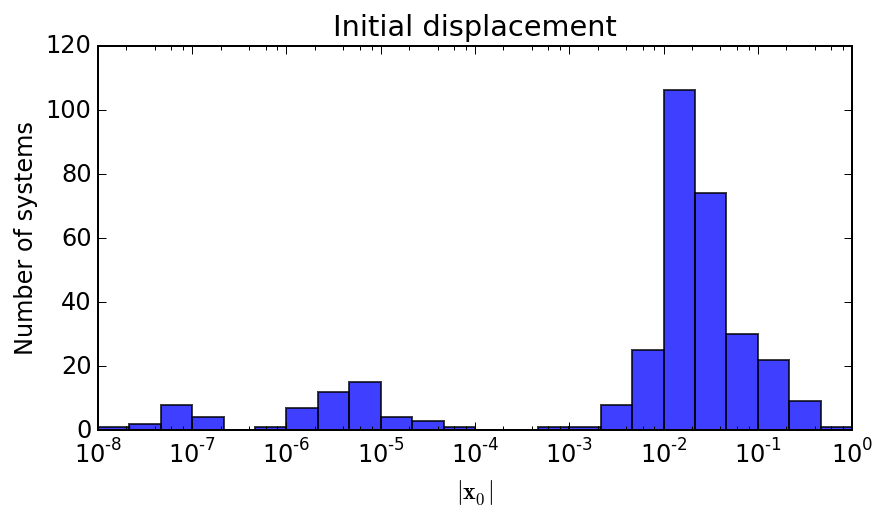

In [410]:
fig = plt.figure(figsize = (6,3.5))
bins = np.logspace(-8.0, 0.0, n_bins)
plt.hist(np.clip(x0_norms,bins[0], bins[-1]), bins=bins, facecolor="blue", alpha=0.75)
plt.gca().set_xscale("log")
plt.xlabel(r"$| \mathbf{x}_0 |$")
plt.ylabel(r"Number of systems")
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: '{:.0f}'.format(int(x))))
plt.title(r"Initial displacement")
plt.tight_layout(pad=0.1)
plt.savefig('InitialDisplacement.pdf', transparent=True);
! pdfcrop InitialDisplacement.pdf InitialDisplacement.pdf
plt.show();

PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `DriftVelocity.pdf'.


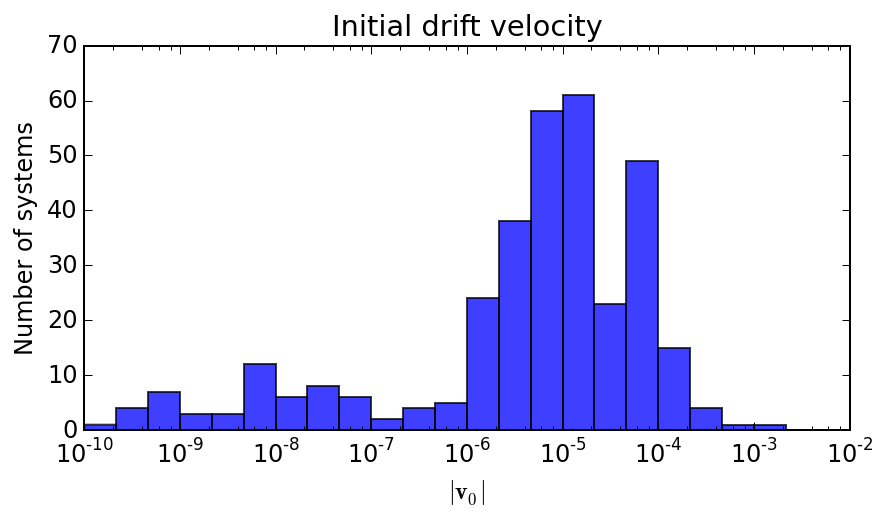

In [413]:
fig = plt.figure(figsize = (6,3.5))
n, bins, patches = plt.hist(v0_norms, bins=np.logspace(-10.0, -2.0, n_bins), facecolor="blue", alpha=0.75)
plt.gca().set_xscale("log")
plt.xlabel(r"$| \mathbf{v}_0 |$")
plt.ylabel(r"Number of systems")
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: '{:.0f}'.format(int(x))))
plt.title(r"Initial drift velocity")
plt.tight_layout(pad=0.1)
plt.savefig('DriftVelocity.pdf', transparent=True);
! pdfcrop DriftVelocity.pdf DriftVelocity.pdf
plt.show();

PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `MaxDisplacement.pdf'.


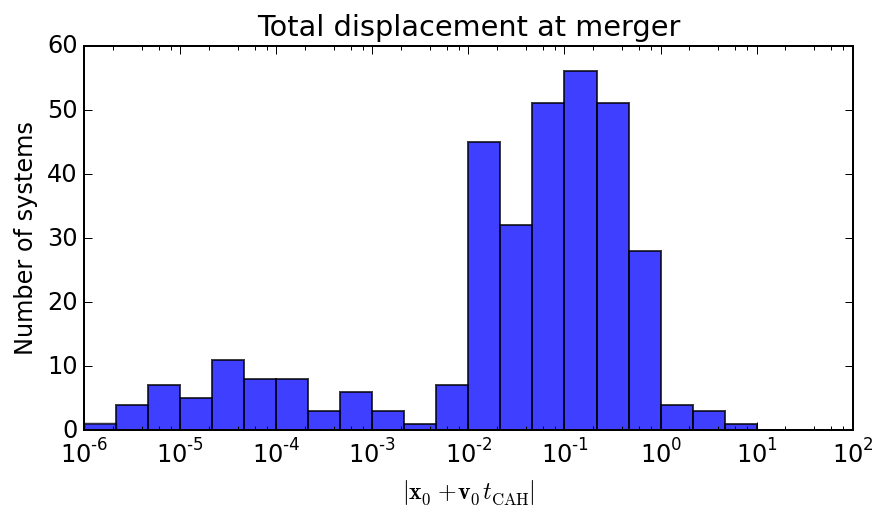

In [414]:
fig = plt.figure(figsize = (6,3.5))
n, bins, patches = plt.hist(d_norms, bins=np.logspace(-6.0, 2.0, n_bins), facecolor="blue", alpha=0.75)
plt.gca().set_xscale("log")
plt.xlabel(r"$| \mathbf{x}_0 + \mathbf{v}_0 t_{\mathrm{CAH}} |$")
plt.ylabel(r"Number of systems")
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: '{:.0f}'.format(int(x))))
plt.title(r"Total displacement at merger")
plt.tight_layout(pad=0.1)
plt.savefig('MaxDisplacement.pdf', transparent=True);
! pdfcrop MaxDisplacement.pdf MaxDisplacement.pdf
plt.show();

# Boosted grid

In [145]:
β = 0.5
α = math.atanh(β)
γ = 1 / math.sqrt(1-β**2)
v = np.array([1, 0, 1])
vhat = v / np.linalg.norm(v)

def Θ(Θp):
    return 2 * math.atan(γ * (1-β) * math.tan(Θp/2))

def R_B(θp, ϕp):
    R = quaternion.from_spherical_coords(θp, ϕp)
    r = (R * quaternion.z * R.inverse()).vec
    Θp = math.acos(np.dot(r, vhat))
    a = -np.cross(r, vhat)
    tmp = np.linalg.norm(a)
    if tmp < 1e-12:
        return quaternion.one
    a = a / tmp
    return ((Θ(Θp) - Θp) * np.quaternion(0, *a) / 2).exp()

n_phi = 17
n_theta = 17
thetaprm_phiprm = np.array([[thetaprm, phiprm]
                             for phiprm in np.linspace(0.0, 2*np.pi, num=n_phi, endpoint=False)
                            for thetaprm in np.linspace(0.0, np.pi, num=n_theta, endpoint=True)])

R_prm = np.array([quaternion.from_spherical_coords(*tp) for tp in thetaprm_phiprm])
r_prm = np.array([(r * quaternion.z * r.inverse()).vec for r in R_prm])
t_prm = np.array([(r * quaternion.x * r.inverse()).vec for r in R_prm])
p_prm = np.array([(r * quaternion.y * r.inverse()).vec for r in R_prm])

R = np.array([R_B(*tp)*quaternion.from_spherical_coords(*tp) for tp in thetaprm_phiprm])
r = np.array([(r * quaternion.z * r.inverse()).vec for r in R])
t = np.array([(r * quaternion.x * r.inverse()).vec for r in R])
p = np.array([(r * quaternion.y * r.inverse()).vec for r in R])

Rr = np.array([np.quaternion(0, 0.1, 0.2, 0.3).exp()*quaternion.from_spherical_coords(*tp) for tp in thetaprm_phiprm])
rr = np.array([(r * quaternion.z * r.inverse()).vec for r in Rr])
tr = np.array([(r * quaternion.x * r.inverse()).vec for r in Rr])
pr = np.array([(r * quaternion.y * r.inverse()).vec for r in Rr])

phase_differences = np.array([math.acos(np.dot([-math.sin(math.atan2(ri[1], ri[0])), math.cos(math.atan2(ri[1], ri[0])), 0], ti))
                              for ri,ti in zip(r,t)])
phase_differencesr = np.array([math.acos(np.dot([-math.sin(math.atan2(ri[1], ri[0])), math.cos(math.atan2(ri[1], ri[0])), 0], ti))
                               for ri,ti in zip(rr,tr)])

PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `OriginalGrid.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `DeboostedGrid.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `DerotatedGrid.pdf'.


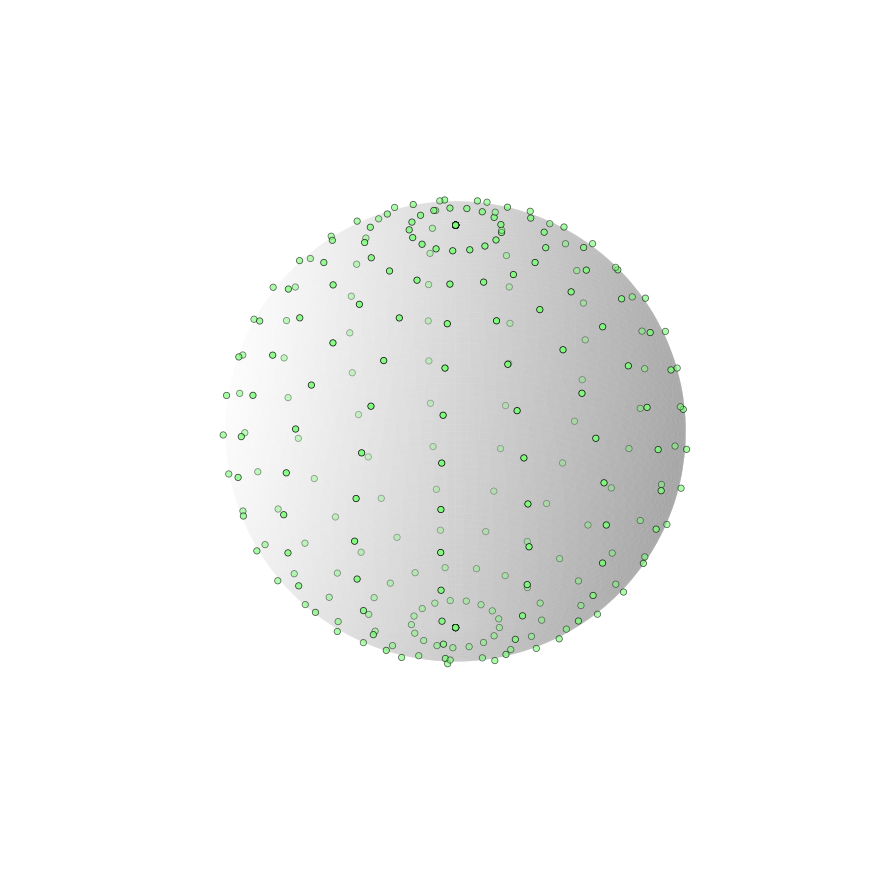

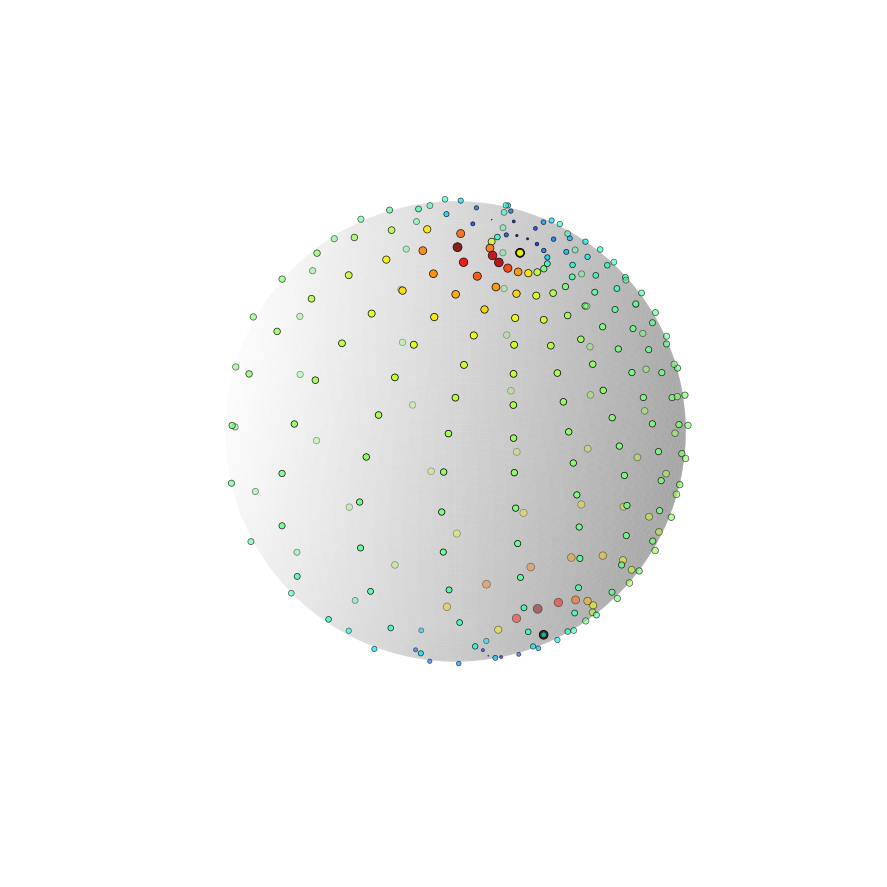

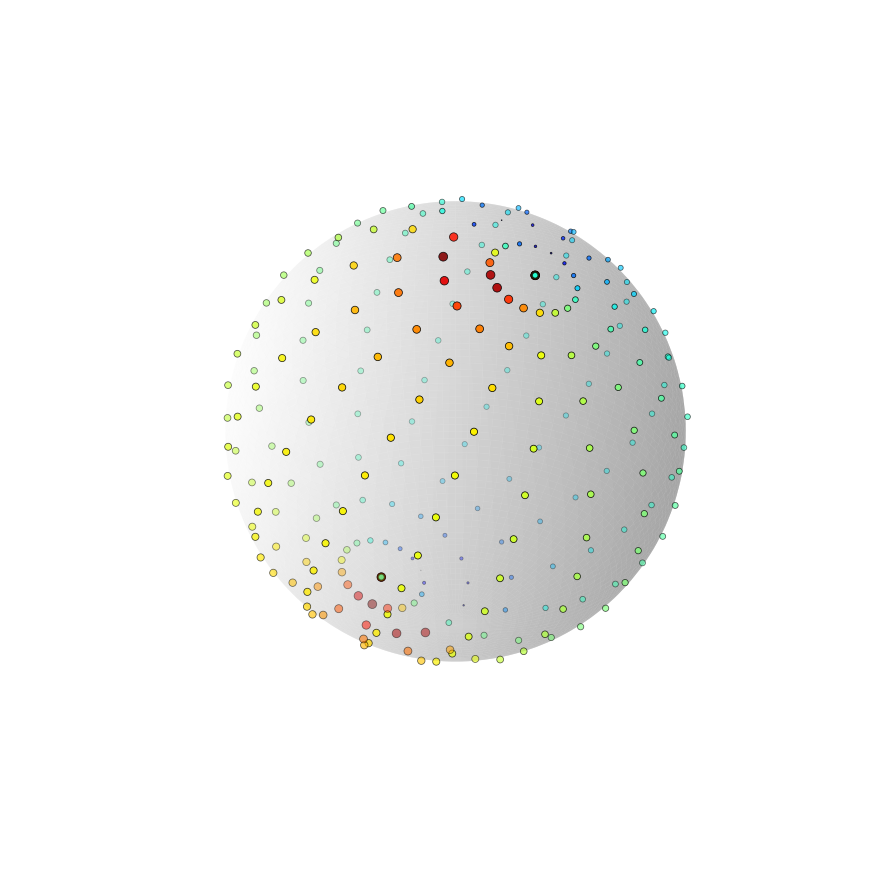

In [426]:
rm=0.99
phi = np.linspace(0, 2 * np.pi, 100)
theta = np.linspace(0, np.pi, 100)
xm = rm * np.outer(np.cos(phi), np.sin(theta))
ym = rm * np.outer(np.sin(phi), np.sin(theta))
zm = rm * np.outer(np.ones(np.size(phi)), np.cos(theta))

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xm, ym, zm, rstride=1, cstride=1, linewidth=0, color=(1, 1, 1, 0.5));
ax.scatter(r_prm[:,0],r_prm[:,1],r_prm[:,2], c=mpl.cm.jet(0.5), s=10, linewidths=0.375);
# ax.plot_wireframe(r_prm[:,0],r_prm[:,1],r_prm[:,2]);
#ax.set_title('Grid as seen in boosted frame');
ax.set_xlim(-1,1);
ax.set_ylim(-1,1);
ax.set_zlim(-1,1);
ax._axis3don = False;
plt.tight_layout(pad=0.1);
plt.savefig('OriginalGrid.pdf', transparent=True);
! pdfcrop OriginalGrid.pdf OriginalGrid.pdf
# Now show that grid "de-boosted" into the original frame
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xm, ym, zm, rstride=1, cstride=1, linewidth=0, color=(1, 1, 1, 0.5));
ax.scatter(r[:,0],r[:,1],r[:,2], c=phase_differences, s=20*phase_differences/math.pi, linewidths=0.375);
# ax.plot_wireframe(r[:,0],r[:,1],r[:,2]);
#ax.set_title('Grid in original frame that will become equi-angular in boosted frame');
ax.set_xlim(-1,1);
ax.set_ylim(-1,1);
ax.set_zlim(-1,1);
ax._axis3don = False;
plt.tight_layout(pad=0.1);
plt.savefig('DeboostedGrid.pdf', transparent=True);
! pdfcrop DeboostedGrid.pdf DeboostedGrid.pdf

# Now show that grid "de-rotated" into the original frame
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xm, ym, zm, rstride=1, cstride=1, linewidth=0, color=(1, 1, 1, 0.5));
ax.scatter(rr[:,0],rr[:,1],rr[:,2], c=phase_differencesr, s=20*phase_differencesr/math.pi, linewidths=0.375);
# ax.plot_wireframe(r[:,0],r[:,1],r[:,2]);
#ax.set_title('Grid in original frame that will become equi-angular in boosted frame');
ax.set_xlim(-1,1);
ax.set_ylim(-1,1);
ax.set_zlim(-1,1);
ax._axis3don = False;
plt.tight_layout(pad=0.1);
plt.savefig('DerotatedGrid.pdf', transparent=True);
! pdfcrop DerotatedGrid.pdf DerotatedGrid.pdf

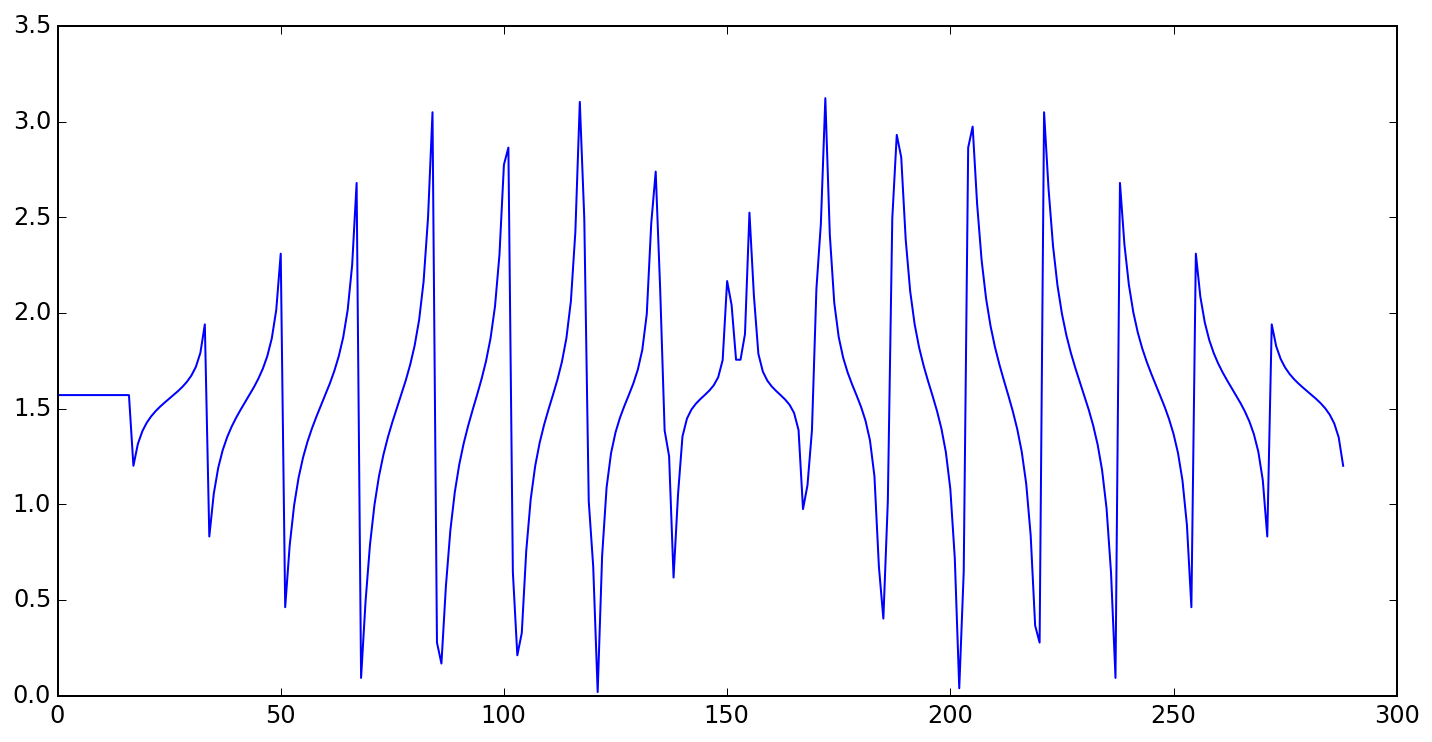

In [148]:
plt.plot(phase_differences)